In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
from pathlib import Path
from os.path import join
os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
import pandas as pd
import numpy as np

from util.files import *
from util.const import *
from util.ddfs import *

In [3]:
# FIPS will be passed in as an argument, one day...
FIPS = '34007'
# STATE ABBR and NATION will be derived from FIPS, one day...
STATEABBR = 'NJ'
NATION = 'US'

# Prepare data for ensemble generation

In [4]:
# Generate structure ensemble
# Merge hazard data in
# Sample from the depth grids
# Add our vulnerability uncertainty
# (it's conditioned on the depth value in 
# a particular state of the world)

## Load and subset exposure data

In [5]:
# Load the single family homes,
# the fd_id/reference file
# the fd_id/depths file
# the fd_id flood zone file
nsi_struct = gpd.read_file(join(EXP_DIR_I, FIPS, 'nsi_sf.gpkg'))
nsi_ref = pd.read_parquet(join(EXP_DIR_I, FIPS, 'nsi_ref.pqt'))
nsi_depths = pd.read_parquet(join(EXP_DIR_I, FIPS, 'nsi_depths.pqt'))
nsi_fz = pd.read_parquet(join(EXP_DIR_I, FIPS, 'nsi_fz.pqt'))

In [6]:
# The point of the code below is to make it so that
# we can draw from triangular distributions
# This is a very case-study specific solution
# Ultimately, we'd like to have a pdf of depths
# to draw from - either a distribution & fitted parameters
# or an empirical distribution
# So, we are going to round depths to the nearest foot
# and we're going to retain the rows that have non-zero
# foot relative to grade depths
# Don't want to bake this processing into the process_haz
# scripts because it is case-study specific

# Round depths to the nearest foot
# We do not have depth-damage functions
# that would make reasonable use of finer precision
nsi_depths = nsi_depths.round()
# Filter to properties with > 0 
nsi_depths = nsi_depths[nsi_depths.iloc[:,1:].sum(axis=1) > 0]

In [7]:
# Need foundation type, number stories, structure value
# for our ensemble. Structure value will be the center of 
# the distribution and will be passed to the loss estimation
# function. Foundation type will be drawn from the implicit
# distribution in the NSI data. For each census block, 
# we are going to get the multinomial probabilities of 
# a building having a certain foundation type & number of stories
# Ideally, we would do this conditioned on prefirm but the
# building year column is based on median year built from ACS
# data
# From the foundation type that is drawn from the multinomial in 
# the ensemble, we will get the FFE from the distribution 
# defined in the code for the Wing et al. 2022 paper
# The point estimate version will just use default values

# Start by retaining only relevant columns in nsi_struct
# Then subset this and nsi_ref to the fd_id in nsi_depths
# We do need sqft for elevation cost or floodproof estimates
keep_cols = ['fd_id', 'occtype', 'found_type', 'val_struct']
nsi_res = nsi_struct[keep_cols]

# Let's merge in refs into nsi_res
nsi_res = nsi_res.merge(nsi_ref, on='fd_id')

# We're also going to merge in fzs
nsi_res = nsi_res.merge(nsi_fz[['fd_id', 'fld_zone']], on='fd_id')

# Split occtype to get the number of stories and basement
# We only need to keep stories for the purposes
# of estimating the distribution that stories comes from
# We will draw basement from the foundation type
# distribution which also gives us first floor elevation
structs = nsi_res['occtype'].str.split('-').str[1]
basements = structs.str[2:]
stories = structs.str[:2]

nsi_res = nsi_res.assign(stories=stories)

# Retain only the rows that correspond to structures
# that are exposed to flood depths
nsi_res_f = nsi_res[nsi_res['fd_id'].isin(nsi_depths['fd_id'])]

# Merge in the depths to the struct df you are working with
# Also merge in the refs - there are inconsistencies
# with the cbfips column from nsi directly and the
# block data I downloaded from the census webpage
# You retain more structures if you use the block data 
full_df = nsi_res_f.merge(nsi_depths, on='fd_id')

# This dataset can be directly used for estimating the 
# benchmark losses of using NSI as-is
# Use the Hazus DDFs with no uncertainty

In [8]:
# Let's get the fld_zone column processed for the way it needs
# to be done for using hazus ddfs
# Get the first character of the flood zone and only retain it
# if it's a V zone. We are going to use A zone for A and outside
# (if any) flood zone depth exposures
ve_zone = np.where(full_df['fld_zone'].str[0] == 'V',
                   'V',
                   'A')
full_df = full_df.assign(fz_ddf = ve_zone)


## Get parameters for structures

In [9]:
# We are also going to use nsi_struct merged with refs
# to determine the multinomial probabilities of basement
# and number stories (binomial) from block level which matches
# up with NSI tech reference on where data is randomly assigned
# from. While there are maps from parcel data, where available, 
# it's not clear which entries have this non-random assignment. 
# In addition, it is known that parcel aggregation datasets like
# ZTRAX may have data errors. The sources the NSI used
# have unknown validation/accuracy so we can treat these as
# part of estimating the distribution to draw from

# The method for estimating number of stories is based on assignment
# from parcel data. Where missing, square footage is divided by the 
# structure's footprint (when sq. ft. is missing, they take 86% of
# the structure's footprint as sq. ft). If > 1.25,
# a second floor is assumed
# If no footprint is available, 
# stories is randomly assigned from a distribution that varies by
# year built and census region. So, we can use census block again
# here

# The methodology for the structure valuation is obscure
# and there is no reporting on how accurate it is to some
# observed data on market values
# In a conservative thrust, we can take the reported
# coefficient of determination from Philadelphia Assesor's 
# methodology for estimating market values. This COD can be
# multiplied by the estimated value from NSI for a presumably
# conservative estimate of the standard deviation surrounding
# structure value estimates to observed market values
# We can also show in a representative example what would
# happen to the loss estimate distribution
# if the NSI COD is a factor of 2 larger. We still don't know
# if this is a reasonable representation since we assume
# there is no bias in the NSI structure valuation by
# centering the noise distribution at their estimated value. 
# In reality, the Philly assessor office reports their estimates
# are slightly biased which allows us to use a bias correction
# factor if we used that data. Down the line, comparing
# what the structure inventory distributions are using different
# data sources could be very interesting, including accounting
# for different # of RES1 buildings based on more detailed
# and survye-based methods in the city assessor data
# From the Nolte et al. (2023) large-scale parcel data good
# practices data, we know that there are many issues in using parcel
# data to fill in important data fields (even occupancy type)
# It is not the panacea it appears framed as in the NSI technical
# documentation

# There are not nearly enough observations at the block level
# to reliably estimate the parameter for binomial # stories
# or multinomial foundation type. Sometimes just one observation
# in general. Tract appears to have enough
# This check is based on the subset of tracts (or other ref)
# in nsi_res that are also in full_df (these are the ones) we need
# the probabilities for
# I guess STRUCT_REF should either be a config, 
# or something identified on-the-fly based on 
# whether we have enough observations at block or blockgroup
# before "rolling back" to coarser resolution to get
# proportions
STRUCT_REF = 'tract_id'
struct_tot = nsi_res[nsi_res[STRUCT_REF].isin(full_df[STRUCT_REF])]


### Number of stories

In [10]:
# Get the total number of structures w/ number of stories 
# in each block gruop
stories_sum = struct_tot.groupby([STRUCT_REF, 'stories']).size()
# Then get the proportion
stories_prop = stories_sum/struct_tot.groupby([STRUCT_REF]).size()
# Our parameters can be drawn from this table based on the bg_id
# of a structure we are estimating losses for
stories_param = stories_prop.reset_index().pivot(index=STRUCT_REF,
                                                 columns='stories',
                                                 values=0).fillna(0)
# Since it's a binomial distribution, we only need to specify
# one param. Arbitrarily choose 1S
# Round the param to the hundredth place
# Store in a dict
stories_param = stories_param['1S'].round(2)
STRY_DICT = dict(stories_param)



### Foundation types

In [11]:
# Repeat procedure above
found_sum = struct_tot.groupby([STRUCT_REF, 'found_type']).size()
found_prop = found_sum/struct_tot.groupby([STRUCT_REF]).size()
found_param = found_prop.reset_index().pivot(index=STRUCT_REF,
                                             columns='found_type',
                                             values=0).fillna(0)

# We want a dictionary of bg_id to a list of B, C, S
# for direct use in our multinomial distribution draw
# Store params in a list (each row is bg_id and corresponds to
# its own probabilities of each foundation type)
params = found_param.values.round(2)
# Then create our dictionary
FND_DICT = dict(zip(found_param.index, params))


## Load depth damage functions

In [12]:
# Load DDFs
naccs_ddfs = pd.read_parquet(join(VULN_DIR_I, 'physical', 'naccs_ddfs.pqt'))
hazus_ddfs = pd.read_parquet(join(VULN_DIR_I, 'physical', 'hazus_ddfs.pqt'))

# Load helper dictionaries
with open(join(VULN_DIR_I, 'physical', 'hazus.json'), 'r') as fp:
    HAZUS_MAX_DICT = json.load(fp)

with open(join(VULN_DIR_I, 'physical', 'hazus_nounc.json'), 'r') as fp:
    HAZUS_MAX_NOUNC_DICT = json.load(fp)

with open(join(VULN_DIR_I, 'physical', 'naccs.json'), 'r') as fp:
    NACCS_MAX_DICT = json.load(fp)

# Generate ensemble

In [13]:
# Reminder of the dataframes/dictionaries we have to help generate
# our ensemble members efficiently
# STRY_DICT
# FND_DICT
# FFE_DICT
# hazus
# naccs
# HAZUS_MAX_DICT
# NACCS_MAX_DICT
# HAZUS_MAX_NOUNC_DICT

# And some constants
# COEF_VARIATION
# N_SOW
# RET_PERS

# We need a randon number generator
rng = np.random.default_rng()

In [14]:
# Need to create a dataframe w/ 10,000 rows for each fd_id
# From full_df, keep fd_id, val_struct, bg_id, and the
# depth columns. 
# The way I usually do this is with
# df.loc[np.repeat(df.index, N)].reset_index(drop=True)
# With this approach, we can do everything in a vectorized
# form by passing array_like data of size N*len(df)
# to different rng() calls to get all the draws from
# distributions that we need
drop_cols = ['occtype', 'found_type', 'block_id', 'fld_zone',
             'stories']

ens_df = full_df.drop(columns=drop_cols)
ens_df = ens_df.loc[np.repeat(ens_df.index, N_SOW)].reset_index(drop=True)
print('Created Index for Ensemble')

Created Index for Ensemble


## Sample depths

In [15]:
# We want to store our sampled depths for each 
# return period in a list
# And will put these in a dataframe later
depths_l = []
# Let's loop through each return period
for rp in RET_PERS:
    # Let's store rp + scen as strings for easy reference
    left = rp + '_Lower'
    mid = rp + '_Mid'
    right = rp + '_Upper'
    
    # Let's create a temporary dataframe with the same index
    # as ens_df and for just the three columns we want to use
    # to draw from a triangular distribution
    draw_df = ens_df[[left, mid, right]].copy()

    # We need a mask for when the left and right are the same
    # In such a case we do not need (and cannot) draw from 
    # a triangular distribution and just need to take one of 
    # the values
    no_tri_mask = draw_df[left] == draw_df[right]

    # Now, we either take the left value, or we draw from
    # the triangular distribution
    draw_df.loc[no_tri_mask, rp] = draw_df.loc[no_tri_mask][left]
    
    draws = rng.triangular(draw_df.loc[~no_tri_mask][left],
                           draw_df.loc[~no_tri_mask][mid],
                           draw_df.loc[~no_tri_mask][right])
    draw_df.loc[~no_tri_mask, rp] = draws

    # Replace 0 values with na
    draw_df.loc[draw_df[rp] == 0, rp] = np.nan
    
    # Now we just want to store the series for our rp
    # in a list which we will concat after all this
    # looping is done
    # This will be our final depth dataframe
    depths_l.append(draw_df[rp])
    
    # Helpful logging message
    print('Got sampled depth values: ' + rp)

# Round sapmled depth to nearest foot
depth_df = pd.concat(depths_l, axis=1).round()


Got sampled depth values: 001
Got sampled depth values: 002
Got sampled depth values: 005
Got sampled depth values: 010
Got sampled depth values: 015
Got sampled depth values: 020
Got sampled depth values: 025
Got sampled depth values: 050
Got sampled depth values: 075
Got sampled depth values: 100
Got sampled depth values: 200
Got sampled depth values: 500


## Sample structure characteristics

In [16]:
# Values
# Draw from the structure value distribution for each property
# normal(val_struct, val_struct*CF_DET) where these are array_like
# I also want to treat this as truncated
# on the lower end since there is a risk of drawing impossibly
# low numbers (like negative) with this approach
# https://github.com/kieranrcampbell/blog-notebooks/blob/master/
# Fast%20vectorized%20sampling%20from%20truncated%
# 20normal%20distributions%20in%20python.ipynb
# outlines an approach to use numpy to do a truncated sample
# TODO move this to a util file
def truncnorm_rvs_recursive(x, sigma, lower_clip):
    rng = np.random.default_rng()
    q = rng.normal(x, sigma)
    if np.any(q < lower_clip):
        # Adjustment to the code provided to index the sigma vector
        q[q < lower_clip] = truncnorm_rvs_recursive(x[q < lower_clip],
                                                    sigma[q < lower_clip],
                                                    lower_clip)

    return q
# Using 20000 as an artificial, arbitrary lower bound on value
values = truncnorm_rvs_recursive(ens_df['val_struct'],
                                 ens_df['val_struct']*COEF_VARIATION,
                                 20000)

print('Draw values')

# Draw from the #stories distribution
# We do this by mapping ens_df values with STRY_DICT
# and passing this parameter to rng.binomial()
# We also need to create an array of 1s with length
# N_SOW * len(full_df) - i.e. len(ens_df)
# full_df['bg_id'].map(STRY_DICT)
bin_n = np.ones(len(ens_df), dtype=np.int8)
bin_p = ens_df[STRUCT_REF].map(STRY_DICT).values
# This gives us an array of 0s and 1s
# Based on how STRY_DICT is defined, the probability of
# success parameter corresponds to 1S, so we need to
# swap out 1 with 1S and 0 with 2S
stories = rng.binomial(bin_n, bin_p)
stories = np.where(stories == 1,
                   '1S',
                   '2S')

print('Draw stories')

# Draw from the fnd_type distribution
# We do the same thing as above but with
# the FND_DICT. This is a multinomial distribution
# and 0, 1, 2 correspond to B, C, S
# We get an array returned of the form 
# [0, 0, 1] (if we have Slab foundation, for example)
# so we need to transform this into the corresponding
# foundation type array
# Can do this with fnds[fnds[0] == 1] = 'B'
# fnds[fnds[1]] == 1] = 'C' & fnds[fnds[2] == 1] = 'S'
# One way to do the mapping is by treating each
# row-array as a binary string and converting it
# to an int
# So you get [a, b, c] => a*2^2 + b*2^1 + c*2^0
# This uniquely maps to 4, 2, and 1
# So we can create a dict for 4: 'B', 2: 'C', and 1: 'S'
# and make it a pd.Series() (I think this is useful because
# pandas can combine this with the 1S and 2S string easily
# into a series and we'll need to use that bld_type
# for the other dicts we have)

# This is our ens_df index aligned multinomial
# probabilities array
# np.stack makes sure the dtype is correct
# Not sure why it is cast to object dtype if
# I call .values, but this works...

mult_p = np.stack(ens_df[STRUCT_REF].map(FND_DICT))
# This is our map of binary string/int
# conversions to the foundation type
bin_str_map = {4: 'B', 2: 'C', 1: 'S'}
# We need our np.ones array 
mult_n = np.ones(len(ens_df), dtype=np.int8)
# Draw from mult_p
fnds = rng.multinomial(mult_n, mult_p)
# Create a series of 4, 2, and 1 from the binary strings
# This code accomplishes the conversion outlined in the
# note above and comes from this stackoverflow post
# https://stackoverflow.com/questions/41069825/
# convert-binary-01-numpy-to-integer-or-binary-string
fnds_ints = pd.Series(fnds.dot(2**np.arange(fnds.shape[1])[::-1]))
# Replace these values with the fnd_type
fnd_types = fnds_ints.map(bin_str_map)


print('Draw foundation type')

# We take fnd_types for two tasks now
# First, if B, it's WB type home and we
# combine this with stories to get the bld_type
# This is naccs_ddf_type 
# We combine bld_type with fz_ddf to get hazus_ddf_type
# For our case study, it turns out we will use the same hazus
# ddf for the basement houses (_A) since no V zone houses
# For no basement, hazus_ddf_type does not add the _fz

# Let's get bld_type
# Basement type from fnd_types
base_types = np.where(fnd_types == 'B',
                      'WB',
                      'NB')

# Combine 1S and this
bld_types = pd.Series(stories) + pd.Series(base_types)

# In theory, bld_type is naccs_ddf_type. No need to 
# take this storage up in practice... just refer to bld_type
# when needed
# For WB homes, hazus_ddf_type is bld_types + '_' + ens_df['fz_ddf']
# For NB homes, it's bld_types
# It makes practical sense to create a new series for this
hazus_ddf_types = pd.Series(np.where(base_types == 'WB',
                                     bld_types + '_' + ens_df['fz_ddf'],
                                     bld_types))

# Second, we are going to use the fnd_type to draw from the
# FFE distribution
# Need to use np.stack to get the array of floats
tri_params = np.stack(fnd_types.map(FFE_DICT))

# Can use [:] to access like a matrix and directly input to 
# rng.triangular
# 0, 1, and 2 are column indices corresponding to left,
# mode, and right
# We round this to the nearest foot
ffes = np.round(rng.triangular(tri_params[:,0],
                               tri_params[:,1],
                               tri_params[:,2]))

print('Generated Structure Characteristics')


Draw values
Draw stories
Draw foundation type
Generated Structure Characteristics


## Estimate losses

In [17]:
# First, we need to link up the depths and ffes
# They have the same index, so I think we can do it by
# just take our depth df and adusting each column
# by the ffe amount
depth_ffe_df = depth_df.subtract(ffes, axis=0)

In [18]:
depths = depth_ffe_df[rp]
ddfs = naccs_ddfs
MAX_DICT = NACCS_MAX_DICT

In [19]:
# Now, we are going to loop through each return period
# and estimate losses for NACCS and HAZUS using our helper
# functions for each of these
# We will store these in dictionaries with return period keys
hazus_loss = {}
naccs_loss = {}
for rp in RET_PERS:
    naccs_loss[rp] = est_naccs_loss(bld_types, depth_ffe_df[rp],
                                    naccs_ddfs, NACCS_MAX_DICT)
    hazus_loss[rp] = est_hazus_loss(hazus_ddf_types, depth_ffe_df[rp],
                                    hazus_ddfs, HAZUS_MAX_DICT)

    print('Estimate Losses for NACCS & Hazus, RP: ' + rp)

# Then, we convert these to dataframes
hazus_df = pd.DataFrame.from_dict(hazus_loss)
naccs_df = pd.DataFrame.from_dict(naccs_loss)

# And we use a binomial rv to determine if we use the hazus or naccs
# loss estimate for a particular return period
# Binomial
random_loss = rng.binomial(1, .5, size=len(ens_df))

# Get indices to take from each df
hazus_ind = (random_loss == 0)
naccs_ind = (random_loss == 1)

# Concat subsetted dataframes
losses_df = pd.concat([hazus_df.loc[hazus_ind],
                       naccs_df.loc[naccs_ind]], axis=0).sort_index()
# Rename columns to make it more clear what this is
losses_df.columns = ['rel_dam_' + x for x in losses_df.columns]

print('Randomly assigned NACCS or HAZUS Loss')

Estimate Losses for NACCS & Hazus, RP: 001
Estimate Losses for NACCS & Hazus, RP: 002
Estimate Losses for NACCS & Hazus, RP: 005
Estimate Losses for NACCS & Hazus, RP: 010
Estimate Losses for NACCS & Hazus, RP: 015
Estimate Losses for NACCS & Hazus, RP: 020
Estimate Losses for NACCS & Hazus, RP: 025
Estimate Losses for NACCS & Hazus, RP: 050
Estimate Losses for NACCS & Hazus, RP: 075
Estimate Losses for NACCS & Hazus, RP: 100
Estimate Losses for NACCS & Hazus, RP: 200
Estimate Losses for NACCS & Hazus, RP: 500
Randomly assigned NACCS or HAZUS Loss


In [20]:
# Now we concat these with ens_df, stories, fnd_type,
# ffe, structure value, and depth_ffe_df
depth_ffe = pd.DataFrame.from_dict(depth_ffe_df)

# Add clearer column names
depth_ffe.columns = ['depth_ffe_' + x for x in depth_ffe.columns]

# Concat for our full ensemble
ens_df = pd.concat([ens_df, losses_df, depth_ffe,
                    pd.Series(stories, name='stories'),
                    pd.Series(fnd_types, name='fnd_type'),
                    pd.Series(ffes, name='ffe'),
                    pd.Series(values, name='val_s')],
                   axis=1)
# Get relative damage columns
rel_cols = [x for x in ens_df.columns if 'rel_dam' in x]
# For each relative damage column, scale by val_s, the structure
# value realization
for col in rel_cols:
    rp = col.split('_')[-1]
    ens_df['loss_' + rp] = ens_df[col]*ens_df['val_s']

print('Obtained Full Ensemble')

Obtained Full Ensemble


In [21]:
# Now we calculate EAL
# We will use trapezoidal approximation for this
# Using trapezoid method and adding bin of lowest probability
# events to obtain expected annual 

# We make a list of our loss columns
loss_list = ['loss_' + x for x in RET_PERS]
# As well as the corresponding probabilities
p_rp_list = [round(1/int(x), 4) for x in RET_PERS]

# Then we create an empty series
eal = pd.Series(index=ens_df.index).fillna(0)

# We loop through our loss list and apply the 
# trapezoidal approximation
for i in range(len(loss_list) - 1):
    loss1 = ens_df[loss_list[i]]
    loss2 = ens_df[loss_list[i+1]]
    rp1 = p_rp_list[i]
    rp2 = p_rp_list[i+1]
    # We add each approximation
    eal += (loss1 + loss2)*(rp1-rp2)/2
# This is the final trapezoid to add in
final_eal = eal + ens_df[loss_list[-1]]*p_rp_list[-1]

# Add eal column to our dataframe
ens_df = pd.concat([ens_df, pd.Series(final_eal, name='eal')], axis=1)

# Let's also get the SOW index - start at 0
sow_ind = np.arange(len(ens_df))%N_SOW
ens_df = pd.concat([ens_df, pd.Series(sow_ind, name='sow_ind')], axis=1)

In [40]:
# Ok this is great. Now I need to write this out
# And, I need to get the no uncertainty benchmark losses as well
# Should be able to plot the benchmark value pdf against
# this pdf, to see how things shake out. Plus, these val vs. risk
# plots would be interesting, to see if you get
# different representations which may have implications for
# the decisions you make later on 
temp = ens_df.groupby('fd_id')[['eal', 'val_s']].mean()
temp['rel_eal'] = temp['eal']/temp['val_s']

<Axes: xlabel='val_s', ylabel='rel_eal'>

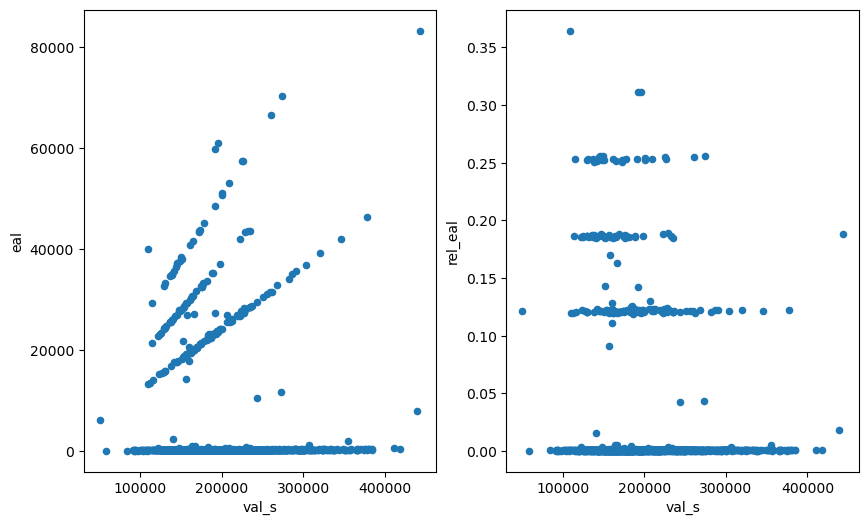

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
temp.plot(x='val_s', y='eal', kind='scatter', ax=ax[0])
temp.plot(x='val_s', y='rel_eal', kind='scatter', ax=ax[1])

# Generate losses without uncertainty

In [73]:
nsi_res.head()

,fd_id,occtype,found_type,val_struct,tract_id,block_id,bg_id,zcta_id,fld_zone,stories
0,550368098,RES1-2SWB,B,216021.012,34007605200,340076052002021,340076052002,08030,X,2S
1,550368104,RES1-1SWB,B,264359.376,34007605200,340076052002021,340076052002,08030,X,1S
2,550368108,RES1-2SWB,B,233771.754,34007605200,340076052002021,340076052002,08030,X,2S
3,550368096,RES1-2SNB,C,246408.102,34007605200,340076052002021,340076052002,08030,X,2S
4,550577105,RES1-1SWB,B,220274.562,34007605200,340076052002008,340076052002,08030,X,1S
